In [1]:
import rampy as rp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from datetime import datetime
import os

from pydantic import BaseModel
from typing import List

import matplotlib.dates as mdates
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

In [2]:
class XRange(BaseModel):
    lower_limit:float
    higher_limit:float

def _select_range(x_range:XRange, data:np.array) -> np.array:
    cond1 = data[:,0] > x_range.lower_limit
    cond2 = data[:,0] < x_range.higher_limit
    cond = cond1 & cond2
    data = data[cond].copy()
    return data

def load_data(filename:str, x_range:XRange=None,  basepath:str="./data") -> np.array:
    # from glob import glob
    import os
    filepath = os.path.join(basepath, f"{filename}")
    if(os.path.exists(filepath) == False):
        raise FileExistsError(f"{filepath=} is not exists")
    spectrum = np.genfromtxt(filepath)
    # Flip X-axis
    spectrum = rp.flipsp(spectrum)
    if(x_range != None):
        assert isinstance(x_range, XRange), f"limit_x must be `XRange`"
        spectrum = _select_range(x_range=x_range, data=spectrum)
    return spectrum

## OGTT result

Let's plot how the OGTT went for s1, s2, s3, and s4

In [3]:
subj_ids = ['s1','s2','s3','s4','s5','s6','s7','s8']
datas = []

basepath = "../../data/pilot"
for subj_id in subj_ids:
    filepath = os.path.join(basepath, f"{subj_id}.csv")
    if(os.path.exists(filepath) == False):
        raise FileExistsError(f"{filepath=} is not found")
    df = pd.read_csv(filepath,parse_dates=['time'], dtype={'glucose':'float',
                                    'prefix':'string'},index_col="time")
    datas.append(df)
    del(df)


In [4]:
today = datetime.today().replace(hour=1, minute=0, second=0, microsecond=0)

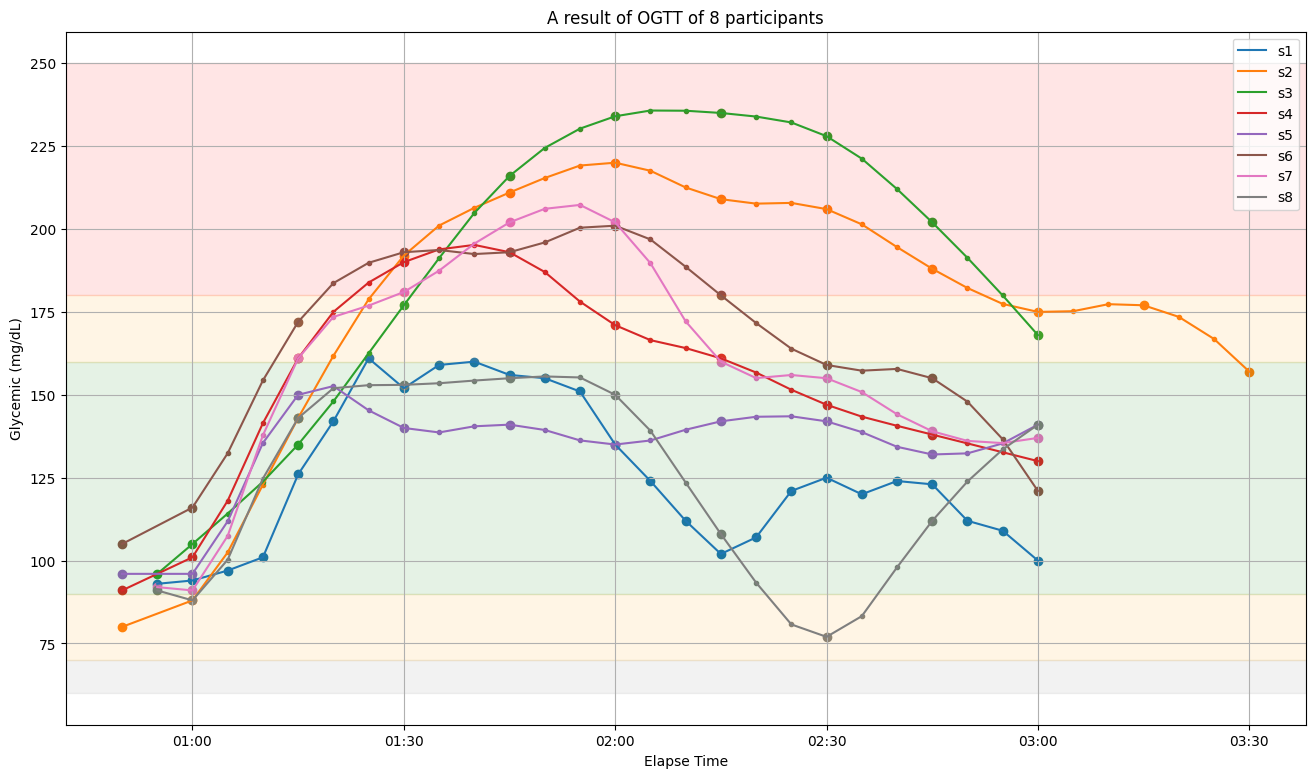

In [5]:
fig, ax = plt.subplots(figsize=(16,9))
color_list = list(colors.TABLEAU_COLORS.values())
for index, (subj_id, data) in enumerate(zip(subj_ids, datas)):
    y = data.glucose
    x = y.index
    y = y.interpolate(method='polynomial', order=2)
    elapse = x - x[1]
    ax.scatter(elapse + today, y, c=color_list[index], marker='.')
    ax.scatter(elapse + today, data.glucose, c=color_list[index])
    ax.plot(elapse + today, y, label=subj_id, color=color_list[index])


ax.set_title("A result of OGTT of 8 participants")
ax.set_xlabel("Elapse Time")
ax.set_ylabel("Glycemic (mg/dL)")
axisx_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(axisx_format)
ax.axhspan(60,70, color='grey', alpha=0.1)
ax.axhspan(70,90, color='orange', alpha=0.1)
ax.axhspan(90,160, color='green', alpha=0.1)
ax.axhspan(160,180, color='orange', alpha=0.1)
ax.axhspan(180,250, color='red', alpha=0.1)
ax.legend()
ax.grid()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
glucoses = []
for subj_id, data in zip(subj_ids, datas):
    x = data.time
    y = data.glucose
    glucoses += y.copy().dropna().to_list()
    elapse = x - x[1]
    ax.scatter(elapse + today,y, label=subj_id)


ax.set_title("A result of OGTT of 8 participants")
ax.set_xlabel("Elapse Time")
ax.set_ylabel("Glycemic (mg/dL)")
axisx_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(axisx_format)
ax.axhspan(60,70, color='grey', alpha=0.1)
ax.axhspan(70,90, color='orange', alpha=0.1)
ax.axhspan(90,160, color='green', alpha=0.1)
ax.axhspan(160,180, color='orange', alpha=0.1)
ax.axhspan(180,250, color='red', alpha=0.1)
ax.legend()
ax.grid()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
bins = range(50,251,10)
N, bins, patches = ax.hist(x=glucoses, bins=bins)
# We'll color code by height, but you could use any scalar
fracs = N / N.max()
# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())
# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

ax.set_title("Glycemic distribution from 8 participants")
ax.set_xlabel("Glycemic (mg/dL)")
ax.set_ylabel("Density")
ax.set_xticks(ticks=bins)
# ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
# ax.axhspan(60,70, color='grey', alpha=0.1)
# ax.axhspan(70,90, color='orange', alpha=0.1)
# ax.axhspan(90,160, color='green', alpha=0.1)
# ax.axhspan(160,180, color='orange', alpha=0.1)
# ax.axhspan(180,250, color='red', alpha=0.1)
# ax.legend()
ax.grid()
plt.show()

## Raman Measurement

In [ ]:
x_range = XRange(lower_limit=900, higher_limit=1500)

# Load data into the column of df
for subj_id,data in zip(subj_ids, datas):
    spectrums = []
    for prefix in data.prefix:
        # Look for a file with this prefix
        file_lookup = os.path.join(basepath,subj_id,f"{prefix}_*")
        lookup_result = sorted(glob(file_lookup))
        assert len(lookup_result) != 0, f"{file_lookup=}, {lookup_result=}"
        # select the latest one
        filepath = lookup_result[-1]
        spectrum = load_data(filename=filepath, x_range=x_range, basepath="")
        spectrums.append(spectrum)
    data['spectrum'] = spectrums
